In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.gen_model import OTFlowMatching, MLP_FM

2023-07-10 13:10:48.048312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np

x0 = np.linspace(-1, 0, 300)
y0 = np.cos(x0) * 5 / + 0.1 * np.random.randn(len(x0))
data0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)

x1 = np.linspace(0, 1, 300)
y1 = np.cos(x1) * 5 + 0.1 * np.random.randn(len(x1))
data1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)

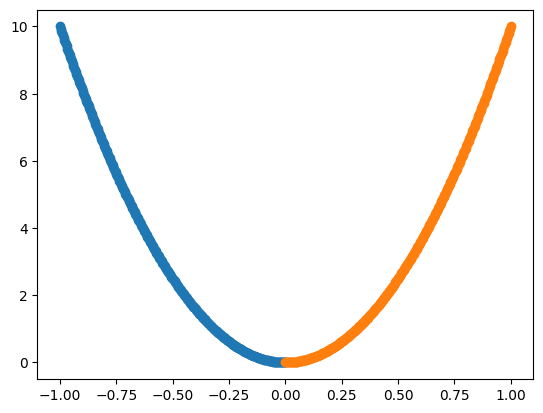

In [4]:
x0 = np.linspace(-1, 0, 300)
x1 = np.linspace(0, 1, 300)

y0 = 10*(x0**2)
y1 = 10*(x1**2)

data1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)
data0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)

plt.scatter(x0,y0)

plt.scatter(x1,y1)

In [5]:
from ott.geometry.pointcloud import PointCloud
from ott.geometry.geometry import Geometry
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


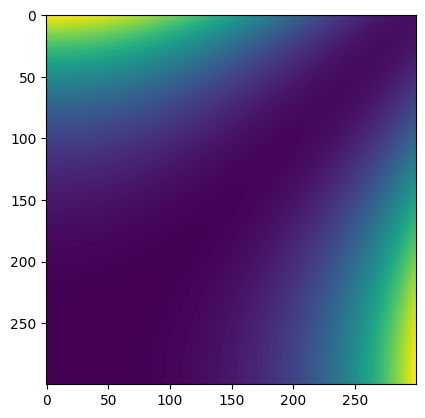

In [6]:
plt.imshow(PointCloud(data0, data1).cost_matrix)

In [7]:
lp = LinearProblem(PointCloud(data0, data1, epsilon=1e-3))

In [8]:
out = Sinkhorn()(lp)

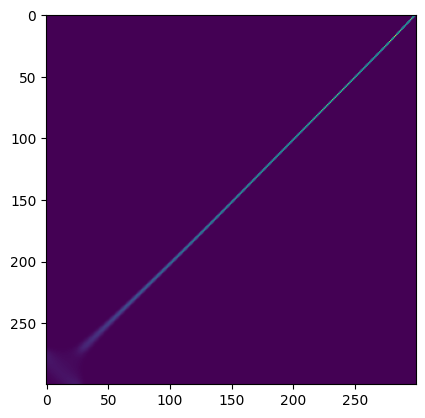

In [9]:
plt.imshow(out.matrix)

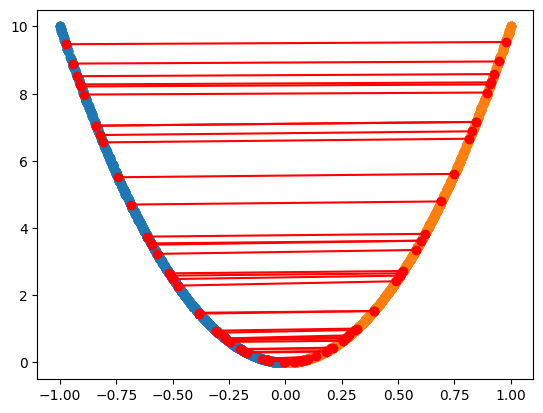

In [10]:
pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=jnp.log(out.matrix.flatten()), shape=(1000,)
    )
inds_source = pi_star_inds // 300
inds_target = pi_star_inds % 300
source_gt = data0[inds_source]
target_gt = data1[inds_target]

plt.scatter(source_gt[:,0], source_gt[:,1])
plt.scatter(target_gt[:,0], target_gt[:,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (40,), 0, len(source_gt))
plt.plot([source_gt[indices, 0],target_gt[indices, 0]],[source_gt[indices, 1],target_gt[indices, 1]] ,'ro-')
plt.show()

In [11]:
import jax

batch_0 = data0[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0)).sort()]
batch_1 = data1[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data1)).sort()]


#batch_0 = data0[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))]
#batch_1 = data1[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data1))]

In [12]:
source_flattened = data0
t_xz_flattened = data1

In [13]:


def get_nearest_neighbors(
    X: jnp.ndarray, Y: jnp.ndarray, len_x: int, k: int = 30  # type: ignore[name-defined]
) -> Tuple[jnp.ndarray, jnp.ndarray]:  # type: ignore[name-defined]
    concat = jnp.concatenate((X,Y), axis=0)
    pairwise_euclidean_distances = pointcloud.PointCloud(concat, concat).cost_matrix
    distances, indices = jax.lax.approx_min_k(pairwise_euclidean_distances, k=k, recall_target=0.95, aggregate_to_topk=True)
    return distances, indices

k_neighbors = 600#len(source_flattened)+1
distances, indices = get_nearest_neighbors(source_flattened, t_xz_flattened, len(source_flattened), k_neighbors)
distances = distances**4
a = jnp.zeros((len(source_flattened)+ len(t_xz_flattened), len(source_flattened)+ len(t_xz_flattened)))
#print(a.shape, len(source_flattened), distances.shape, indices.shape)
adj_matrix = a.at[jnp.repeat(jnp.arange(len(source_flattened)+len(t_xz_flattened)), repeats=k_neighbors).flatten(), indices.flatten()].set(distances.flatten())
cm = ott.geometry.graph.Graph.from_graph(adj_matrix, normalize=True).cost_matrix


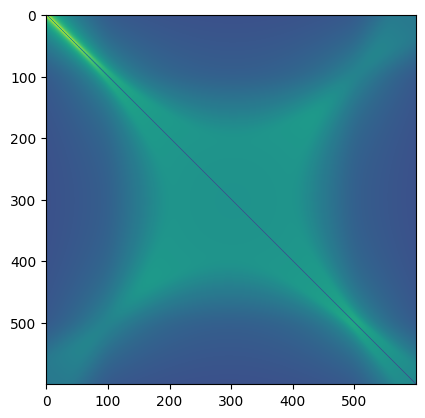

In [14]:
plt.imshow(cm)

In [15]:
geom = geometry.Geometry(cm[:300, 300:], epsilon=1e-4)
sinkhorn_output = sinkhorn.Sinkhorn()(
            linear_problem.LinearProblem(geom)  # linear_problem.LinearProblem(geom, a=a, b=b)
        )

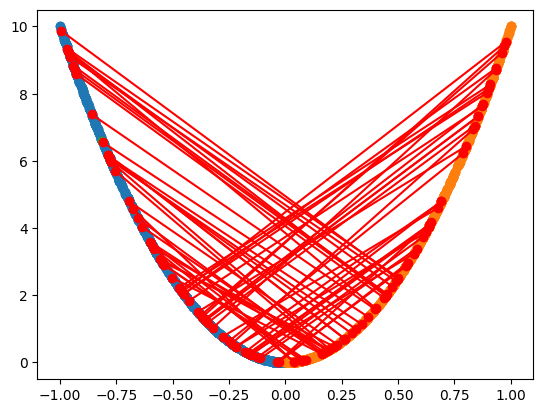

In [16]:
pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=jnp.log(sinkhorn_output.matrix.flatten()), shape=(1000,)
    )
inds_source = pi_star_inds // 300
inds_target = pi_star_inds % 300
source_gt = data0[inds_source]
target_gt = data1[inds_target]

plt.scatter(source_gt[:,0], source_gt[:,1])
plt.scatter(target_gt[:,0], target_gt[:,1])
plt.scatter(source_gt[0,0], source_gt[0,1])
plt.scatter(target_gt[0,0], target_gt[0,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (60,), 0, len(source_gt))
plt.plot([source_gt[indices, 0],target_gt[indices, 0]],[source_gt[indices, 1],target_gt[indices, 1]] ,'ro-')
plt.show()

In [47]:
neural_net = MLP_FM([128, 128, 128, 128], n_frequencies=1)
otfm = OTFlowMatching(neural_net, epsilon=1e-2, cost_fn="graph", input_dim=2, output_dim=2, iterations=300, k_neighbors=256*2)

In [52]:
#kg(jnp.array(data0)[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))], jnp.array(data1)[jax.random.randint(jax.random.PRNGKey(0), (64,), 0, len(data0))], 64, 64)
otfm(data0, data1, 256, 256)

100%|██████████| 300/300 [16:04<00:00,  3.21s/it]


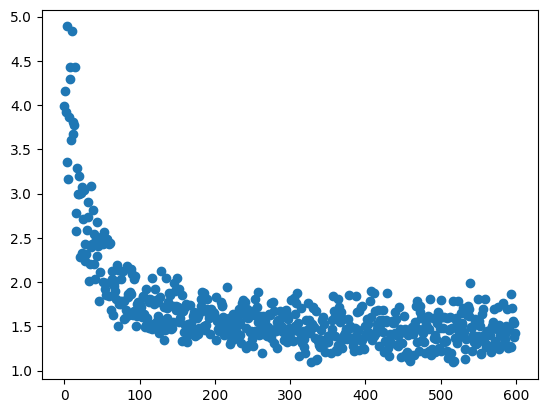

In [53]:
plt.scatter(np.arange(len(otfm.metrics['loss'])), otfm.metrics['loss'])

In [54]:
pushed_source, _ = otfm.transport(data0, 1, 0)
pushed_source_2, _ = otfm.transport(data0, 1, 1)

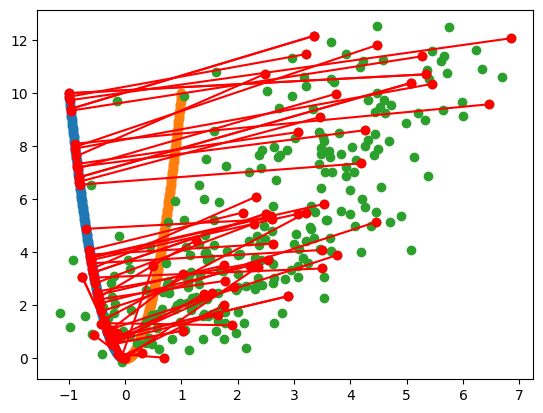

In [55]:
plt.scatter(data0[:,0], data0[:,1])
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(pushed_source[0,:,0], pushed_source[0,:,1])
indices = jax.random.randint(jax.random.PRNGKey(0), (60,), 0, len(data0))

plt.plot([data0[indices, 0],pushed_source[0, indices, 0]],[data0[indices, 1],pushed_source[0, indices, 1]] ,'ro-')
plt.show()

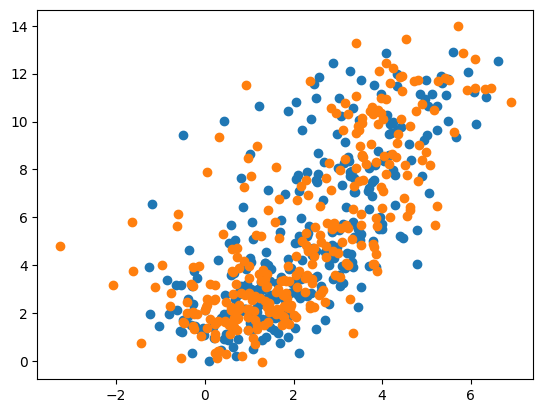

In [46]:
plt.scatter(pushed_source[0,:,0], pushed_source[0,:,1])
plt.scatter(pushed_source_2[0,:,0], pushed_source_2[0,:,1])